## 1. Présentation du projet et du dataset

### 1.1 Contexte du projet
Dans ce projet, nous allons construire et entraîner un réseau de neurones convolutifs (CNN) pour classer des images de fruits, légumes et noix à l’aide du **Fruits-360 dataset**.

### 1.2 Description du dataset (Fruits-360)
Le **Fruits-360 dataset** (version 2024.08.04.0) contient des images de différentes sortes de fruits, légumes et noix. Voici les points clés :

- **Nombre total d’images** : 94 110 images (redimensionnées à 100×100 pixels).  
- **Jeu d’entraînement (Training)** : 70 491 images.  
- **Jeu de test (Test)** : 23 619 images.  
- **Nombre de classes** : 141 (chaque variété d’un même fruit forme une classe distincte).  
- **Format des images** :  
  - Dimensions : 100×100 pixels.  
  - Fichiers nommés sous forme `image_index_100.jpg`, ou `r_image_index_100.jpg` (pour des images de fruits légèrement tournées), etc.  
- **Organisation des répertoires** : deux dossiers “Training” et “Test”.  
- **Méthode de capture** :  
  - Les fruits (ou légumes) sont filmés sur un moteur à faible vitesse.  
  - La caméra utilisée est une **Logitech C920**.  
  - Un algorithme de “flood fill” a ensuite été appliqué pour extraire le fruit (ou légume) du fond blanc.  

Pour plus de détails, vous pouvez consulter la page Kaggle :  
[https://www.kaggle.com/moltean/fruits](https://www.kaggle.com/moltean/fruits)

## 2. Préparation de l’environnement et téléchargement des données

Dans cette section, nous allons :  
1. Importer les librairies nécessaires,  
2. Importer notre fichier `kaggle.json` pour autoriser le téléchargement des données depuis Kaggle,  
3. Monter notre Google Drive,  
4. Configurer le fichier `kaggle.json`,  
5. Télécharger et dézipper le dataset Fruits-360 dans Google Drive.


In [12]:
# =========================================
# 1. Importations des librairies nécessaires
# =========================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

# Keras et TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Pour l'évaluation
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random

# Pour l'import/export de fichiers dans Colab
from google.colab import files
from google.colab import drive

In [ ]:
# =========================================
# 2. Configuration Kaggle et téléchargement des données
# =========================================

# -- A) Chargement du fichier kaggle.json --
print("Veuillez sélectionner votre fichier 'kaggle.json' (cliquez sur 'Choose Files')")
uploaded = files.upload()  # Permet de charger le fichier kaggle.json dans l'environnement Colab

# -- B) Montage de Google Drive --
# On monte Google Drive pour y accéder depuis Colab
drive.mount('/content/drive')

# -- C) Création d'un répertoire de travail dans Google Drive --
drive_dir = "/content/drive/MyDrive/mon_projet_fruits360"
os.makedirs(drive_dir, exist_ok=True)

# -- D) Configuration du fichier kaggle.json local --
# Copie du fichier kaggle.json dans le répertoire ~/.kaggle et réglage des permissions
kaggle_json_local = "kaggle.json"
!mkdir -p ~/.kaggle
!cp "$kaggle_json_local" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# -- E) Téléchargement du dataset depuis Kaggle --
# On se place dans le dossier de travail sur Drive
os.chdir(drive_dir)

# Télécharge le dataset fruits-360 (moltean/fruits)
# -d : nom du dataset Kaggle
# -o : overwrite des fichiers si déjà existants
!kaggle datasets download -d moltean/fruits -o

# -- F) Décompression du dataset --
# Vérifie si le dossier 'fruits_dataset' existe déjà. Sinon, on dézippe le fichier téléchargé.
if not os.path.exists("fruits_dataset"):
    !unzip -q fruits.zip -d fruits_dataset
else:
    print("Le dossier 'fruits_dataset' existe déjà, on ne dézippe pas à nouveau.")

À la fin de l’exécution de cette section, le dossier spécifié (`/content/drive/MyDrive/mon_projet_fruits360`) contient :  
- Un fichier `fruits.zip` téléchargé,  
- Un dossier `fruits_dataset` contenant le jeu de données décompressé.

## 3. Exploration des données

### 3.1 Vérification du contenu du dossier `fruits_dataset`
Avant de préparer les données pour l’entraînement et la validation, il est indispensable de **comprendre** la structure du dossier `fruit_dataset` que nous venons de télécharger et décompresser.

In [7]:
# Chemin principal vers le dossier fruits_dataset
dataset_root_dir = os.path.join(drive_dir, "fruits_dataset")

print("Contenu du dossier 'fruits_dataset':")
print(os.listdir(dataset_root_dir))

Contenu du dossier 'fruits_dataset':
['fruits-360_dataset_100x100', 'fruits-360_dataset_original-size']


Nous observons que le dossier `fruit_dataset` contient **deux versions** :

1. La version contenant les images dans leur taille originale ou de taille variable nommée `fruits-360_dataset_original-size`.  
2. La version **redimensionnée à 100×100** pixels nommée `fruits-360_dataset_100x100`.  

Dans notre projet, nous utiliserons la version **100×100** dont nous avons parlé lors de la présentation du dataset.

### 3.2 Vérification du contenu du dossier `fruits-360_dataset_100x100`
Nous allons cibler le **dossier `fruits-360_dataset_100x100`**, qui correspond à la version redimensionnée.  

In [9]:
base_dir = os.path.join(drive_dir, "fruits_dataset", "fruits-360_dataset_100x100", "fruits-360")
print("Contenu du dossier 'fruits-360_dataset_100x100':")
print(os.listdir(base_dir))

Contenu du dossier 'fruits-360_dataset_100x100':
['LICENSE', 'readme.md', 'Test', 'Training']


C’est à l’intérieur de ce dossier que se trouvent les sous-dossiers `Training` et `Test`.

### 3.3 Contenu de `Training` et `Test`

In [10]:
train_full_dir = os.path.join(base_dir, "Training")
test_dir = os.path.join(base_dir, "Test")

print("\nContenu de 'Training':")
print(os.listdir(train_full_dir)[:10], "...")  # On affiche seulement les 10 premiers pour l'exemple

print("\nContenu de 'Test':")
print(os.listdir(test_dir)[:10], "...")


Contenu de 'Training':
['Apple 6', 'Apple Braeburn 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2'] ...

Contenu de 'Test':
['Apple 6', 'Apple Braeburn 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2'] ...


On remarque que `Training` et `Test` sont organisés en sous-dossiers, chacun représentant une **classe**.

### 3.4 Affichage de quelques images aléatoires
Pour nous faire une idée plus concrète du contenu, affichons **10 images** aléatoires provenant du dossier `Training` chacune avec un titre indiquant la classe.

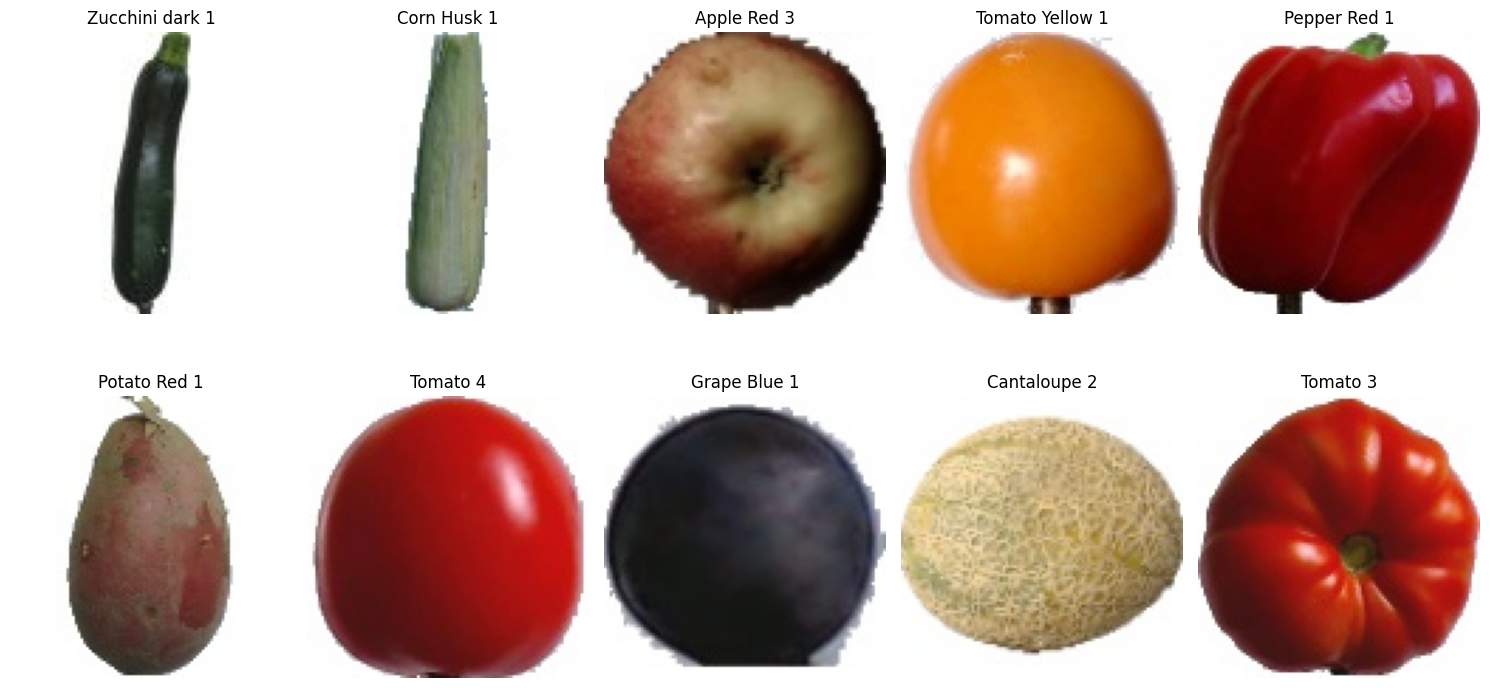

In [13]:
# On récupère toutes les classes (noms des sous-dossiers) dans Training
classes_list = os.listdir(train_full_dir)

# Sélection aléatoire de 10 classes
sample_classes = random.sample(classes_list, 10)

plt.figure(figsize=(15, 8))

for i, class_name in enumerate(sample_classes, start=1):
    # Chemin vers le dossier de la classe
    class_folder = os.path.join(train_full_dir, class_name)
    # Liste de toutes les images dans ce dossier
    image_files = glob.glob(os.path.join(class_folder, "*.jpg"))

    # On en choisit une image au hasard
    if len(image_files) > 0:
        img_path = random.choice(image_files)
        img = plt.imread(img_path)

        plt.subplot(2, 5, i)  # 2 lignes, 5 colonnes
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

plt.tight_layout()
plt.show()


### 3.5 Vérification du nombre total de classes

In [14]:
nb_classes = len(classes_list)
print(f"Nombre total de classes dans le dataset 100x100 : {nb_classes}")

Nombre total de classes dans le dataset 100x100 : 141


## 4. Préparation des données pour l’entraînement et la validation

Dans cette section, nous allons préparer nos données pour l’apprentissage du réseau de neurones. Plus précisément :

- **(A) Préparation du chemin pour sauvegarder le meilleur modèle** :  
  Nous allons définir un emplacement où sera **enregistré** le meilleur modèle (celui qui a la plus haute précision sur la validation). Cela facilite la récupération ultérieure du modèle pour l’inférence ou des tests supplémentaires.

- **(B) Création des Data Generators** :  
  Nous utilisons un **ImageDataGenerator** pour appliquer plusieurs **transformations** (augmentations) aux images du jeu d’entraînement, telles que des rotations, des décalages ou des flips horizontaux. L’objectif est de **rendre le modèle plus robuste** aux variations et d’**éviter** le surapprentissage.  
  - Nous spécifions également `rescale=1./255` pour **normaliser** les pixels dans la plage [0,1].  
  - Le paramètre `validation_split=0.2` réserve 20 % des images du dossier `Training` pour la **validation** qui permet de surveiller le phénomène de **surapprentissage** (overfitting) et d’**arrêter** ou **ajuster** si besoin.

- **(C) Générateur pour l’entraînement** :  
  En utilisant le `train_datagen` configuré à l’étape (B), nous créons un générateur (`train_generator`) qui va **charger** automatiquement les images d’entraînement, leur appliquer les transformations, et fournir au modèle des lots (batches) de données.  
  - Nous indiquons `subset='training'` pour qu’il ne prenne que 80 % des images (puisque 20 % sont réservées à la validation).  
  - Les images seront classées avec le mode `categorical` (one-hot encoding).
  - Le choix de `batch_size=32` est un **compromis** entre la vitesse de traitement (plus le batch est grand, plus il faut de mémoire) et la stabilité de l’optimisation.

- **(D) Générateur pour la validation** :  
  De la même manière, le `val_generator` va charger les **20 %** d’images restantes pour la **validation** (option `subset='validation'`).  
  - Même taille d’image (100×100), même batch size (32).  

À la fin, nous affichons le **nombre d’images** utilisées pour l’entraînement et la validation, ainsi que le **nombre de classes** détectées.

In [15]:
# =========================================
# 4. Préparation des données pour l'entraînement et la validation
# =========================================

# -- A) Préparation du chemin pour sauvegarder le meilleur modèle --
# Définition de l'emplacement où le meilleur modèle sera enregistré
best_model_path = os.path.join(drive_dir, "best_model.keras")

# -- B) Création des Data Generators pour l'entraînement et la validation --
# Utilisation d'ImageDataGenerator pour normaliser et augmenter les données.
# L'argument validation_split=0.2 réserve 20% des images pour la validation.
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalise les pixels de [0,255] à [0,1]
    rotation_range=20,        # Applique des rotations jusqu'à 20° pour varier les perspectives
    width_shift_range=0.2,    # Décalage horizontal aléatoire
    height_shift_range=0.2,   # Décalage vertical aléatoire
    shear_range=0.2,          # Cisaillement (distorsion) dans l'image
    zoom_range=0.2,           # Zoom aléatoire sur l'image
    horizontal_flip=True,     # Retourne l'image horizontalement
    fill_mode='nearest',      # Remplit les zones vides créées par les transformations
    validation_split=0.2      # Réserve 20% des données pour la validation
)

# -- C) Générateur pour l'entraînement (subset='training') --
# Charge 80% des images (training), applique les transformations définies plus haut.
train_generator = train_datagen.flow_from_directory(
    directory=train_full_dir,   # Dossier contenant les classes
    target_size=(100, 100),     # Redimensionne les images à 100 x 100
    batch_size=32,             # Taille de lot (batch size)
    class_mode='categorical',   # On traite un problème de classification à multiples classes
    subset='training'           # Indique que c'est pour l'entraînement
)

# -- D) Générateur pour la validation (subset='validation') --
# Charge les 20% restants pour valider le modèle
val_generator = train_datagen.flow_from_directory(
    directory=train_full_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# -- E) Informations sur le nombre d'images et de classes détectées --
print(f"Train images : {train_generator.n}")
print(f"Val images   : {val_generator.n}")
print(f"Classes détectées (train) : {train_generator.num_classes}")

Found 56432 images belonging to 141 classes.
Found 14059 images belonging to 141 classes.
Train images : 56432
Val images   : 14059
Classes détectées (train) : 141


## 5. Construction du modèle CNN

Dans cette section, nous construisons un réseau de neurones convolutifs (CNN) en plusieurs blocs de convolution et de pooling, suivis de couches fully-connected.  
Notre objectif est de **capturer** progressivement des caractéristiques de plus en plus **complexes** et **abstraites** des images (ex. bords, formes, motifs), puis de les combiner pour effectuer la **classification finale**.

### 5.1 Choix d’architecture et explications

1. **Détermination du nombre de classes**  
   - Nous récupérons la variable `num_classes` directement depuis le générateur.  
   - Cela garantit que la dernière couche de sortie aura le **même nombre de neurones** que de catégories à prédire (141).

2. **Séquence de blocs Convolution + Pooling**  
   - Nous utilisons trois “blocs” successifs, chacun contenant :  
     - 1 ou 2 couches de convolution (Conv2D) : elles apprennent des filtres détectant des motifs dans l’image (ex. contours, textures).  
     - 1 couche de MaxPooling2D : elle **réduit** la dimension spatiale, rendant l’extraction de caractéristiques plus **invariante** aux petites translations et diminuant la taille des données.  
     - 1 couche de BatchNormalization : normalise les activations pour **stabiliser** l’apprentissage et accélérer la convergence.  
     - 1 Dropout : coupe aléatoirement certaines connexions pour **prévenir** le surapprentissage.  

3. **Taille des filtres**  
   - Des filtres 3×3 sont un **standard** de facto en CNN. Ils permettent de capturer des motifs locaux tout en restant peu coûteux en paramètres.

4. **Progression des canaux de convolution** (32 → 64 → 128)  
   - Nous commençons avec **32 filtres**, puis **64**, et enfin **128**.  
   - Cette **progression** est fréquente : plus on avance dans le réseau, plus on apprend des caractéristiques de haut niveau (et plus on a besoin de canaux pour les représenter).

5. **Couches fully-connected**  
   - Après le **Flatten**, nous ajoutons une couche Dense de **256 neurones** (avec activation ReLU) pour combiner les caractéristiques extraites.  
   - Ensuite, un Dropout de 0.5 pour réduire encore le risque d’**overfitting**.  
   - Enfin, la **couche de sortie** (Dense) a un nombre de neurones égal à `num_classes`, avec une activation **softmax** pour obtenir des probabilités de classe.

6. **Compilation du modèle**  
   - Nous utilisons l’optimiseur **Adam** pour sa robustesse et sa rapidité de convergence.  
   - La fonction de perte **categorical_crossentropy** est le standard pour la classification multi-classes.  
   - Nous suivons la **métrique d’accuracy** pour évaluer la qualité de la classification.

7. **Résumé du modèle**  
   - La commande `model.summary()` permet de **visualiser** la taille et la forme de chaque couche, ainsi que le **nombre total de paramètres** à entraîner.

In [ ]:
# =========================================
# 5. Construction du modèle CNN
# =========================================

# -- A) Détermination du nombre de classes --
# On récupère le nombre de classes depuis le train_generator.
# Cela permettra d'adapter la couche de sortie en fonction du dataset.
num_classes = train_generator.num_classes

# -- B) Création d'un modèle séquentiel --
# Le modèle 'Sequential' facilite l'empilement des couches les unes à la suite des autres.
model = Sequential()

# Bloc 1
# Première couche de convolution 3x3 avec 32 filtres, activation ReLU.
# input_shape=(100, 100, 3) indique que chaque image est de taille 100x100 avec 3 canaux (R, G, B).
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))  # Deuxième convolution 3x3, 32 filtres
model.add(MaxPooling2D(pool_size=(2, 2)))         # Réduction dimensionnelle par max-pooling
model.add(BatchNormalization())                    # Normalise les activations pour accélérer l'apprentissage
model.add(Dropout(0.25))                           # Dropout pour réduire le surapprentissage

# Bloc 2
# On double le nombre de filtres (64). Toujours des filtres 3x3 avec activation ReLU.
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Bloc 3
# On augmente encore le nombre de filtres (128) pour apprendre des caractéristiques plus complexes.
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Couche de Flatten
# Convertit la matrice 2D (hauteur, largeur, canaux) en un vecteur 1D pour la partie fully-connected.
model.add(Flatten())

# Couche fully-connected (Dense)
# 256 neurones, activation ReLU.
# Ajout d'un dropout de 0.5 pour éviter l'overfitting.
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Couche de sortie
# Nombre de neurones = nombre de classes, activation softmax pour obtenir des probabilités.
model.add(Dense(num_classes, activation='softmax'))

# -- C) Compilation du modèle --
# Choix de l'optimiseur (adam), fonction de perte (categorical_crossentropy) et métrique (accuracy).
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -- D) Résumé du modèle --
# Affiche la structure des couches, dimensions et nombre de paramètres entraînables.
model.summary()

Voici le **résultat du `model.summary()`**:

| Layer (type)                   | Output Shape       | Param #   |
|--------------------------------|--------------------|-----------|
| **conv2d (Conv2D)**            | (None, 98, 98, 32) | 896       |
| **conv2d_1 (Conv2D)**          | (None, 96, 96, 32) | 9,248     |
| **max_pooling2d (MaxPooling2D)**       | (None, 48, 48, 32) | 0         |
| **batch_normalization (BatchNormalization)** | (None, 48, 48, 32) | 128       |
| **dropout (Dropout)**          | (None, 48, 48, 32) | 0         |
| **conv2d_2 (Conv2D)**          | (None, 46, 46, 64) | 18,496    |
| **conv2d_3 (Conv2D)**          | (None, 44, 44, 64) | 36,928    |
| **max_pooling2d_1 (MaxPooling2D)**     | (None, 22, 22, 64) | 0         |
| **batch_normalization_1 (BatchNormalization)** | (None, 22, 22, 64) | 256       |
| **dropout_1 (Dropout)**        | (None, 22, 22, 64) | 0         |
| **conv2d_4 (Conv2D)**          | (None, 20, 20, 128)| 73,856    |
| **conv2d_5 (Conv2D)**          | (None, 18, 18, 128)| 147,584   |
| **max_pooling2d_2 (MaxPooling2D)**     | (None, 9, 9, 128)  | 0         |
| **batch_normalization_2 (BatchNormalization)** | (None, 9, 9, 128)  | 512       |
| **dropout_2 (Dropout)**        | (None, 9, 9, 128)  | 0         |
| **flatten (Flatten)**          | (None, 10368)      | 0         |
| **dense (Dense)**              | (None, 256)        | 2,654,464 |
| **dropout_3 (Dropout)**        | (None, 256)        | 0         |
| **dense_1 (Dense)**            | (None, 141)        | 36,237    |

**Total params**: 2,978,605  
**Trainable params**: 2,978,157  
**Non-trainable params**: 448

## 6. Mise en place des Callbacks

Lorsque nous entraînons un réseau de neurones, il est souvent utile d’utiliser des **Callbacks** pour **surveiller**, **contrôler** et **améliorer** le processus d’apprentissage. Dans notre projet, nous employons trois Callbacks clés :

1. **EarlyStopping**  
   - **But** : éviter un surentraînement (overfitting) et un temps d’entraînement excessif.  
   - **Principe** : surveiller la **perte** (loss) sur le jeu de validation. Si celle-ci n’améliore plus pendant un certain nombre d’époques (`patience`), on arrête l’entraînement.  
   - **restore_best_weights** : à la fin, on restaure les poids du meilleur modèle observé (celui avec la plus faible loss de validation).

2. **ModelCheckpoint**  
   - **But** : conserver le **meilleur modèle** obtenu pendant l’entraînement.  
   - **Principe** : à chaque époque, on évalue la **précision** (accuracy) sur la validation. Si elle s’améliore, on enregistre le modèle sur le disque.  
   - **monitor='val_accuracy'** : on se base sur la métrique `accuracy`.  
   - **mode='max'** : on veut **maximiser** cette métrique.  

3. **ReduceLROnPlateau**  
   - **But** : adapter le **taux d’apprentissage (learning rate)** en fonction de la stagnation.  
   - **Principe** : si la loss de validation ne s’améliore plus après `patience` époques, on diminue (facteur `factor=0.1`) le learning rate afin de continuer à optimiser finement.  
   - **min_lr=1e-6** : on impose un taux minimal pour éviter de trop réduire l’apprentissage.

Ces Callbacks aident à **accélérer** la convergence, **optimiser** la performance et **rendre plus robuste** l’apprentissage.

In [ ]:
# =========================================
# 6. Mise en place des Callbacks
# =========================================

# -- A) Arrêt anticipé (EarlyStopping) --
# Surveille la perte sur la validation (val_loss).
# Si pas d'amélioration pendant 3 époques, on arrête et on restaure les meilleurs poids.
early_stop = EarlyStopping(
    monitor='val_loss',        # On surveille la perte sur le jeu de validation
    patience=3,                # Nombre d'époques sans amélioration avant l'arrêt
    restore_best_weights=True  # Restaure les poids du meilleur modèle (val_loss la plus basse)
)

# -- B) Sauvegarde du meilleur modèle (ModelCheckpoint) --
# Surveille l'accuracy sur la validation (val_accuracy).
# Sauvegarde le modèle uniquement si l'accuracy s'améliore.
checkpoint = ModelCheckpoint(
    best_model_path,           # Chemin de sauvegarde du fichier .keras
    monitor='val_accuracy',    # On surveille la précision sur le jeu de validation
    save_best_only=True,       # Ne sauvegarde que le meilleur
    mode='max',                # On veut maximiser l’accuracy
    verbose=1                  # Affiche un message quand un nouveau meilleur modèle est enregistré
)

# -- C) Réduction du taux d'apprentissage (ReduceLROnPlateau) --
# Diminue le learning rate par un facteur 0.1
# si la perte de validation n'améliore plus (val_loss).
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',        # On surveille la perte sur le jeu de validation
    factor=0.1,                # Facteur de réduction (LR = LR * 0.1)
    patience=2,                # Réduit le LR si pas d'amélioration après 2 époques
    min_lr=1e-6,               # LR minimum
    verbose=1                  # Affiche un message quand le LR est modifié
)

## 7. Entraînement du modèle

Nous allons maintenant **entraîner** le réseau CNN construit précédemment sur 15 époques, avec :
- Le générateur `train_generator` (80% des données pour l’entraînement),
- Le générateur `val_generator` (20% des données pour la validation),
- Les **Callbacks** définis à l’étape précédente (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau).

L’objectif est de surveiller l’**évolution** des métriques (accuracy et loss) au fil des époques, de **stocker** le meilleur modèle et de **réduire** le learning rate quand la perte de validation stagne.

### 7.1 Code d’entraînement

In [ ]:
# =========================================
# 7. Entraînement du modèle
# =========================================

epochs = 15  # Nombre maximal d'époques

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stop, checkpoint, reduce_lr]  # On active les callbacks
)

### 7.2 Résultats et analyse

Ci-dessous, un aperçu des **logs** générés (extraits) pendant l’entraînement :

- Le **EarlyStopping** est configuré pour surveiller la perte de validation (`val_loss`) sur 3 époques de patience.
- Le **ModelCheckpoint** enregistre un nouveau fichier `best_model.keras` lorsque `val_accuracy` s’améliore.
- Le **ReduceLROnPlateau** diminue le **learning rate** (à 0.0001, puis 0.00001, etc.) lorsqu’il n’y a plus d’amélioration sur la `val_loss`.

#### Tableau récapitulatif des métriques (exemple)

| **Epoch** | **Train Accuracy** | **Val Accuracy** | **Train Loss** | **Val Loss** | **Learning Rate** |
|:--------:|:------------------:|:---------------:|:--------------:|:------------:|:-----------------:|
| 1  | 0.5812 | 0.6323 | 3.7621 | 1.1213 | 1.0e-3 |
| 2  | 0.5958 | 0.7169 | 1.4445 | 0.8539 | 1.0e-3 |
| 3  | 0.6857 | 0.8107 | 1.0000 | 0.5923 | 1.0e-3 |
| 4  | 0.7568 | 0.8269 | 0.7714 | 0.5493 | 1.0e-3 |
| 5  | 0.8019 | 0.7800 | 0.6197 | 0.7988 | 1.0e-3 |
| 6  | 0.8365 | 0.8310 | 0.5107 | 0.6563 | 1.0e-3 |
| 7  | 0.8925 | 0.9527 | 0.3255 | 0.3255 | 1.0e-4 |
| 8  | 0.9137 | 0.9570 | 0.2600 | 0.1357 | 1.0e-4 |
| 9  | 0.9186 | 0.9588 | 0.2460 | 0.1279 | 1.0e-4 |
| 10 | 0.9283 | 0.9605 | 0.2185 | 0.1224 | 1.0e-4 |
| 11 | 0.9302 | 0.9605 | 0.2077 | 0.1403 | 1.0e-4 |
| 12 | 0.9362 | 0.9605 | 0.1916 | 0.1419 | 1.0e-4 |
| 13 | 0.9419 | 0.9646 | 0.1789 | 0.1201 | 1.0e-5 |
| 14 | 0.9426 | 0.9646 | 0.1732 | 0.1166 | 1.0e-5 |
| 15 | 0.9428 | 0.9625 | 0.1697 | 0.1181 | 1.0e-5 |

#### Analyse des performances

1. **Progression de l’accuracy** :  
   - On passe d’environ **63 %** de précision en validation à plus de **95-96 %** en quelques époques.
   - L’entraînement est efficace, car l’augmentation de la `val_accuracy` est régulière.

2. **Réduction du learning rate** :  
   - Après quelques époques sans amélioration significative de la `val_loss`, `ReduceLROnPlateau` abaisse le LR, ce qui aide à affiner davantage l’entraînement (voir les époques 6, 12, etc.).

3. **Meilleure validation accuracy** :  
   - Le meilleur score de validation se situe vers **0.9646** (96.46 %) à l’époque 13-14.
   - Le modèle **checkpoint** (best_model.keras) est donc enregistré à cette époque.

4. **Stabilisation** :  
   - On constate une relative stabilisation vers la fin (époque 14-15), avec une légère oscillation autour de **96-97 %** de val_accuracy.

### 7.3 Réutilisation du modèle sauvegardé

Après l’entraînement, nous disposons d’un **fichier** (`best_model.keras`) qui correspond au **meilleur modèle** (en termes d’accuracy de validation). Pour **réutiliser** ce modèle sans ré-entraîner tout le réseau, nous pouvons simplement le **charger** et l’employer.

Voici comment procéder :

In [ ]:
# Charger un modèle Keras sauvegardé
from tensorflow.keras.models import load_model

# Indiquez le chemin où se trouve le fichier best_model.keras
best_model_path = os.path.join(drive_dir, "best_model.keras")

# Chargement du modèle
loaded_model = load_model(best_model_path)

# Vérifier la structure pour s'assurer qu'il est bien restauré
loaded_model.summary()


Ainsi, nous économisons du temps de calcul et pouvons facilement **déployer** ou **distribuer** notre modèle. En fait, c'est ce modèle que nous avons soumis pour ce projet.

## 8. Visualisation des courbes d’apprentissage

Lorsque nous entraînons un réseau de neurones, il est essentiel de **visualiser** l’évolution de l’accuracy et de la loss (pour l’entraînement et la validation). Cela permet de :

- Détecter un **éventuel surapprentissage** (overfitting) si la courbe de validation se dégrade pendant que la courbe d’entraînement continue de s’améliorer.  
- Vérifier si l’entraînement **converge** (stabilisation des pertes et augmentation de la précision).  
- Observer si la **validation** et l’entraînement **suivent** des trajectoires cohérentes.

### 8.1 Code de tracé des courbes


In [ ]:
# =========================================
# 8. Visualisation des courbes d'apprentissage
# =========================================

def plot_learning_curves(history):
    """
    Trace les courbes d'accuracy et de perte pour l'entraînement et la validation.
    history : objet History retourné par model.fit()
    """
    # Récupération des métriques stockées dans l'objet History
    acc = history.history['accuracy']       # Précision sur le jeu d'entraînement
    val_acc = history.history['val_accuracy']  # Précision sur le jeu de validation
    loss = history.history['loss']          # Perte sur le jeu d'entraînement
    val_loss = history.history['val_loss']  # Perte sur le jeu de validation

    # Génération d'un intervalle qui correspond au nombre d'époques
    epochs_range = range(len(acc))

    # Taille de la figure
    plt.figure(figsize=(12, 4))

    # Sous-graphe 1 : Accuracy (à gauche)
    plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, première position
    plt.plot(epochs_range, acc, label='Train Accuracy')   # Courbe de la précision sur le train
    plt.plot(epochs_range, val_acc, label='Val Accuracy') # Courbe de la précision sur la validation
    plt.legend()          # Affiche la légende
    plt.title('Accuracy') # Titre du sous-graphe

    # Sous-graphe 2 : Loss (à droite)
    plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, deuxième position
    plt.plot(epochs_range, loss, label='Train Loss')      # Courbe de la perte sur le train
    plt.plot(epochs_range, val_loss, label='Val Loss')    # Courbe de la perte sur la validation
    plt.legend()
    plt.title('Loss')

    # Affichage de la figure complète
    plt.show()

# Appel de la fonction de tracé
plot_learning_curves(history)

### 8.2 Analyse des courbes d’apprentissage

#### Courbes affichées
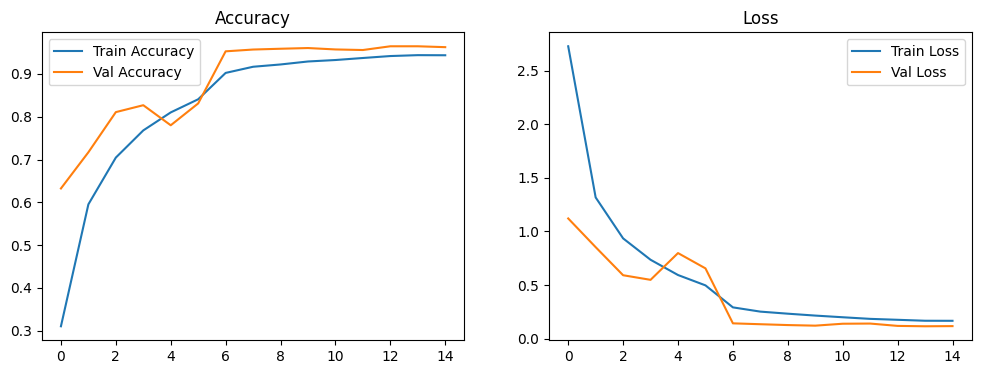

- **Courbe d’Accuracy** :  
  - Au début, la précision sur le train (ligne bleue) était ~30-40%, puis grimpe progressivement jusqu’à ~93-95%.  
  - La précision de validation (ligne orange) suit globalement la même tendance (avec parfois une hausse plus rapide ou plus lente).  
  - Le fait que la courbe de validation **rejoigne** ou **dépasse** brièvement la courbe d’entraînement peut indiquer un bon équilibre, et non un surapprentissage massif.

- **Courbe de Loss** :  
  - Au commencement, la perte est assez élevée (>2.5 ou 3.0).  
  - Puis elle **décroît** régulièrement, indiquant que le réseau apprend à mieux classer les images.  
  - La **loss de validation** suit également une tendance descendante, même si elle peut parfois rebondir (légère remontée) en cas de petite divergence ou de changement de learning rate.

#### Interprétation générale
1. **Convergence** : Les courbes montrent qu’après un certain nombre d’époques, la perte se stabilise et l’accuracy plafonne, indiquant que le modèle a trouvé une **zone d’optimum**.  
2. **Écart Train/Val** : Un trop grand **écart** pourrait signaler de l’**overfitting** (si la train accuracy est bien supérieure à la val accuracy). Ici, l’écart semble raisonnable, donc le surapprentissage est **contenu**.

## 9. Évaluation sur le jeu de Test

Une fois notre modèle entraîné et validé, nous devons mesurer ses performances **réelles** sur un jeu de test **jamais vu** pendant l’entraînement ni la validation. Cela permet d’obtenir une **estimation objective** de sa capacité de généralisation.

### 9.1 Code d’évaluation


In [ ]:
# =========================================
# 9. Évaluation sur le jeu de Test
# =========================================

# -- A) Création d'un DataGenerator pour le test --
# Nous n'appliquons ici pas d'augmentations, uniquement une normalisation des pixels (rescale=1./255).
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,        # Chemin vers le dossier Test
    target_size=(100, 100),    # Redimension des images à 100 x 100
    batch_size=32,             # Taille du batch
    class_mode='categorical',  # Classification multi-classes
    shuffle=False              # Les données ne sont pas mélangées (utile pour matrice de confusion ultérieure)
)

# -- B) Évaluation du modèle sur les données de test --
# On réinitialise le test_generator pour s'assurer de partir du début
test_generator.reset()

# La méthode model.evaluate() renvoie [loss_test, acc_test]
# - loss_test : perte (loss) moyenne sur l'ensemble du test
# - acc_test : précision (accuracy) sur l'ensemble du test
loss_test, acc_test = model.evaluate(test_generator)

print(f"Test Accuracy: {acc_test:.4f}")

### 9.2 Résultats et interprétation

- **Logs affichés** :  
  ```
  Found 23619 images belonging to 141 classes.
  739/739 ━━━━━━━━━━━━━━━━━━━━ 88s 119ms/step - accuracy: 0.9728 - loss: 0.1039
  Test Accuracy: 0.9710
  ```

**Analyse** :
1. **Taux de réussite (accuracy) de ~97 %** : C’est un très bon score, compte tenu du **grand nombre** de classes (141) et de la **variété** des fruits/légumes/nuts.  
2. **Cohérence avec la validation** : Si l’accuracy de validation était aux alentours de 96-97 %, avoir ~97 % sur le test indique que le modèle **généralise** bien et ne s’est pas surentraîné sur le jeu d’entraînement.  
3. **Faible perte (loss)** : Une loss autour de 0.10 est assez basse ; elle reflète une bonne **confiance** du modèle dans ses prédictions.  

## 10. Matrice de confusion et rapport de classification

Après avoir évalué notre modèle sur le jeu de test, nous pouvons examiner **en détail** quelles classes sont correctement prédites et quelles classes posent problème. C’est l’objectif de la **matrice de confusion** et du **rapport de classification** :

- La **matrice de confusion** indique, pour chaque classe réelle (en ligne), la répartition des prédictions (en colonne).  
- Le **rapport de classification** donne, pour chaque classe :  
  - **precision** : parmi les prédictions de cette classe, combien sont correctes ?  
  - **recall** : parmi les images réelles de cette classe, combien sont bien détectées ?  
  - **f1-score** : moyenne harmonique entre la precision et le recall (indicateur global).  
  - **support** : nombre d’images réelles de cette classe dans le test.

### 10.1 Code

In [ ]:
# =========================================
# 10. Matrice de confusion et rapport de classification
# =========================================

test_generator.reset()

# -- A) Prédictions sur le jeu de test --
y_pred_prob = model.predict(test_generator)     # Probabilités pour chaque classe (sortie softmax)
y_pred_classes = np.argmax(y_pred_prob, axis=1) # Conversion en index de classe (ex: 0, 1, 2, ...)

# -- B) Récupération des classes réelles --
y_true = test_generator.classes  # y_true contient l'index de la classe réelle pour chaque image

print("Shape y_pred_classes :", y_pred_classes.shape)
print("Shape y_true :", y_true.shape)

# -- C) Matrice de confusion --
cm = confusion_matrix(y_true, y_pred_classes)
print("Matrice de confusion (format tableau) :\n", cm)

# Affichage visuel de la matrice avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap='Blues', annot=False, fmt='d')  # annot=False pour ne pas surcharger, fmt='d' => nombres entiers
plt.title('Matrice de confusion')
plt.xlabel('Classes prédites')
plt.ylabel('Classes réelles')
plt.show()

# -- D) Rapport de classification --
print("Classification Report :")
report = classification_report(y_true, y_pred_classes, zero_division=0)
print(report)

---

### 10.2 Résultats et interprétation

**Extrait des logs** :

```
Found 23619 images belonging to 141 classes.
Shape y_pred_classes : (23619,)
Shape y_true : (23619,)
Matrice de confusion (format tableau) :
 [[157   0   0 ...   0   0   0]
 [  0 164   0 ...   0   0   0]
 [  0   0 114 ...   0   0   0]
  ...
 [  0   0   0 ... 157   0   0]
 [  0   0   0 ...   0  80   0]
 [  0   0   0 ...   0   0  80]]
```

#### 1) Matrice de confusion (visuelle)

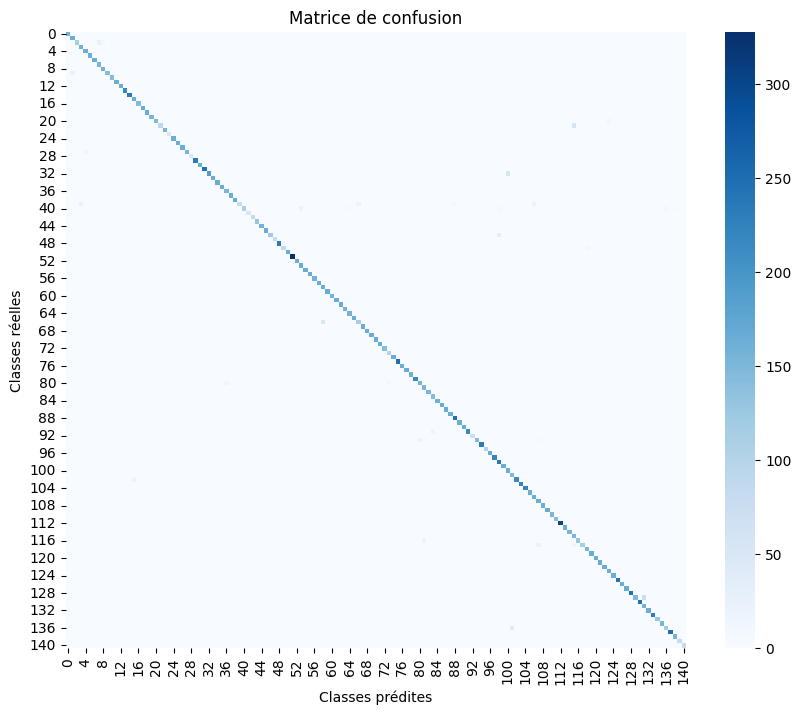

- On observe une **diagonale** dominante : la plupart des images réelles (en ligne) sont prédites dans la même classe (en colonne).  
- Les quelques cases hors diagonale correspondent aux **confusions** entre certaines catégories.

#### 2) Rapport de classification (f1-score, etc.)

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.99      | 1.00   | 1.00     | 157     |
| 1     | 0.88      | 1.00   | 0.94     | 164     |
| 2     | 1.00      | 0.77   | 0.87     | 148     |
| 3     | 0.88      | 1.00   | 0.94     | 160     |
| 4     | 0.92      | 1.00   | 0.96     | 164     |
| 5     | 1.00      | 1.00   | 1.00     | 161     |
| 6     | 1.00      | 1.00   | 1.00     | 164     |
| 7     | 0.85      | 1.00   | 0.92     | 152     |
| 8     | 0.95      | 0.96   | 0.96     | 164     |
| 9     | 1.00      | 0.87   | 0.93     | 164     |
| 10    | 0.96      | 1.00   | 0.98     | 144     |
| 11    | 1.00      | 1.00   | 1.00     | 166     |
| 12    | 1.00      | 1.00   | 1.00     | 164     |
| 13    | 1.00      | 1.00   | 1.00     | 219     |
| 14    | 1.00      | 1.00   | 1.00     | 234     |
| 15    | 0.90      | 1.00   | 0.95     | 164     |
| 16    | 1.00      | 1.00   | 1.00     | 143     |
| 17    | 1.00      | 1.00   | 1.00     | 166     |
| 18    | 1.00      | 0.99   | 1.00     | 166     |
| 19    | 1.00      | 1.00   | 1.00     | 152     |
| 20    | 1.00      | 0.89   | 0.94     | 166     |
| 21    | 0.99      | 0.61   | 0.76     | 150     |
| 22    | 1.00      | 1.00   | 1.00     | 154     |
| 23    | 1.00      | 1.00   | 1.00     | 47      |
| 24    | 1.00      | 1.00   | 1.00     | 166     |
| 25    | 1.00      | 1.00   | 1.00     | 164     |
| 26    | 1.00      | 1.00   | 1.00     | 164     |
| 27    | 1.00      | 0.92   | 0.96     | 166     |
| 28    | 1.00      | 1.00   | 1.00     | 50      |
| 29    | 1.00      | 1.00   | 1.00     | 234     |
| 30    | 1.00      | 1.00   | 1.00     | 164     |
| 31    | 1.00      | 1.00   | 1.00     | 246     |
| 32    | 1.00      | 0.77   | 0.87     | 246     |
| 33    | 1.00      | 1.00   | 1.00     | 164     |
| 34    | 1.00      | 1.00   | 1.00     | 164     |
| 35    | 1.00      | 1.00   | 1.00     | 164     |
| 36    | 0.89      | 1.00   | 0.94     | 153     |
| 37    | 1.00      | 1.00   | 1.00     | 166     |
| 38    | 1.00      | 1.00   | 1.00     | 166     |
| 39    | 0.99      | 0.51   | 0.68     | 150     |
| 40    | 1.00      | 0.71   | 0.83     | 154     |
| 41    | 1.00      | 1.00   | 1.00     | 50      |
| 42    | 1.00      | 1.00   | 1.00     | 81      |
| 43    | 1.00      | 1.00   | 1.00     | 130     |
| 44    | 1.00      | 1.00   | 1.00     | 156     |
| 45    | 1.00      | 1.00   | 1.00     | 166     |
| 46    | 1.00      | 0.78   | 0.87     | 156     |
| 47    | 1.00      | 1.00   | 1.00     | 80      |
| 48    | 1.00      | 1.00   | 1.00     | 234     |
| 49    | 1.00      | 0.89   | 0.94     | 99      |
| 50    | 1.00      | 1.00   | 1.00     | 166     |
| 51    | 1.00      | 1.00   | 1.00     | 328     |
| 52    | 1.00      | 1.00   | 1.00     | 164     |
| 53    | 0.90      | 1.00   | 0.95     | 166     |
| 54    | 1.00      | 1.00   | 1.00     | 166     |
| 55    | 1.00      | 1.00   | 1.00     | 164     |
| 56    | 1.00      | 1.00   | 1.00     | 158     |
| 57    | 1.00      | 1.00   | 1.00     | 166     |
| 58    | 0.76      | 1.00   | 0.87     | 164     |
| 59    | 1.00      | 1.00   | 1.00     | 166     |
| 60    | 1.00      | 1.00   | 1.00     | 157     |
| 61    | 1.00      | 1.00   | 1.00     | 166     |
| 62    | 1.00      | 1.00   | 1.00     | 166     |
| 63    | 1.00      | 1.00   | 1.00     | 156     |
| 64    | 0.96      | 1.00   | 0.98     | 157     |
| 65    | 1.00      | 1.00   | 1.00     | 166     |
| 66    | 0.85      | 0.69   | 0.76     | 164     |
| 67    | 1.00      | 1.00   | 1.00     | 166     |
| 68    | 1.00      | 1.00   | 1.00     | 166     |
| 69    | 1.00      | 1.00   | 1.00     | 166     |
| 70    | 1.00      | 1.00   | 1.00     | 166     |
| 71    | 1.00      | 1.00   | 1.00     | 166     |
| 72    | 1.00      | 1.00   | 1.00     | 142     |
| 73    | 0.92      | 1.00   | 0.96     | 102     |
| 74    | 1.00      | 0.99   | 1.00     | 166     |
| 75    | 1.00      | 1.00   | 1.00     | 246     |
| 76    | 1.00      | 1.00   | 1.00     | 164     |
| 77    | 1.00      | 1.00   | 1.00     | 164     |
| 78    | 1.00      | 1.00   | 1.00     | 160     |
| 79    | 1.00      | 1.00   | 1.00     | 218     |
| 80    | 0.89      | 0.86   | 0.88     | 178     |
| 81    | 0.88      | 1.00   | 0.93     | 150     |
| 82    | 1.00      | 1.00   | 1.00     | 155     |
| 83    | 0.89      | 1.00   | 0.94     | 146     |
| 84    | 1.00      | 1.00   | 1.00     | 160     |
| 85    | 1.00      | 1.00   | 1.00     | 164     |
| 86    | 1.00      | 1.00   | 1.00     | 166     |
| 87    | 1.00      | 1.00   | 1.00     | 164     |
| 88    | 0.97      | 1.00   | 0.99     | 246     |
| 89    | 1.00      | 1.00   | 1.00     | 164     |
| 90    | 1.00      | 1.00   | 1.00     | 164     |
| 91    | 1.00      | 0.93   | 0.96     | 232     |
| 92    | 1.00      | 1.00   | 1.00     | 72      |
| 93    | 1.00      | 0.87   | 0.93     | 166     |
| 94    | 1.00      | 1.00   | 1.00     | 234     |
| 95    | 0.99      | 1.00   | 1.00     | 102     |
| 96    | 1.00      | 1.00   | 1.00     | 166     |
| 97    | 1.00      | 1.00   | 1.00     | 222     |
| 98    | 0.85      | 1.00   | 0.92     | 237     |
| 99    | 1.00      | 1.00   | 1.00     | 166     |
| 100   | 0.75      | 1.00   | 0.86     | 166     |
| 101   | 0.79      | 1.00   | 0.88     | 148     |
| 102   | 1.00      | 0.92   | 0.96     | 234     |
| 103   | 1.00      | 1.00   | 1.00     | 222     |
| 104   | 1.00      | 1.00   | 1.00     | 222     |
| 105   | 1.00      | 1.00   | 1.00     | 164     |
| 106   | 0.88      | 0.99   | 0.93     | 164     |
| 107   | 0.88      | 1.00   | 0.94     | 166     |
| 108   | 1.00      | 1.00   | 1.00     | 163     |
| 109   | 1.00      | 1.00   | 1.00     | 166     |
| 110   | 1.00      | 1.00   | 1.00     | 151     |
| 111   | 1.00      | 1.00   | 1.00     | 142     |
| 112   | 1.00      | 1.00   | 1.00     | 304     |
| 113   | 1.00      | 1.00   | 1.00     | 164     |
| 114   | 1.00      | 1.00   | 1.00     | 153     |
| 115   | 0.67      | 1.00   | 0.80     | 150     |
| 116   | 1.00      | 0.86   | 0.93     | 151     |
| 117   | 1.00      | 0.76   | 0.86     | 150     |
| 118   | 0.94      | 1.00   | 0.97     | 150     |
| 119   | 1.00      | 1.00   | 1.00     | 166     |
| 120   | 1.00      | 1.00   | 1.00     | 164     |
| 121   | 1.00      | 1.00   | 1.00     | 166     |
| 122   | 1.00      | 1.00   | 1.00     | 164     |
| 123   | 0.92      | 1.00   | 0.96     | 162     |
| 124   | 1.00      | 1.00   | 1.00     | 164     |
| 125   | 0.99      | 0.99   | 0.99     | 246     |
| 126   | 1.00      | 1.00   | 1.00     | 166     |
| 127   | 1.00      | 1.00   | 1.00     | 166     |
| 128   | 1.00      | 1.00   | 1.00     | 246     |
| 129   | 1.00      | 0.66   | 0.80     | 225     |
| 130   | 1.00      | 1.00   | 1.00     | 246     |
| 131   | 0.68      | 1.00   | 0.81     | 160     |
| 132   | 1.00      | 1.00   | 1.00     | 164     |
| 133   | 1.00      | 1.00   | 1.00     | 228     |
| 134   | 1.00      | 1.00   | 1.00     | 127     |
| 135   | 1.00      | 1.00   | 1.00     | 153     |
| 136   | 0.94      | 0.75   | 0.83     | 158     |
| 137   | 1.00      | 1.00   | 1.00     | 249     |
| 138   | 0.96      | 1.00   | 0.98     | 157     |
| 139   | 1.00      | 1.00   | 1.00     | 80      |
| 140   | 1.00      | 1.00   | 1.00     | 80      |
| accuracy   |      |    | 0.97     | 23619     |
| macro avg   | 0.97      | 0.97   | 0.97     | 23619      |
| weighted avg   | 0.98      | 0.97   | 0.97     | 23619      |    

- Chaque **ligne** représente une classe (de 0 à 140).  
- **precision** : fraction des images prédites pour cette classe qui sont exactes.  
- **recall** : fraction des images réelles de cette classe qui sont bien détectées.  
- **f1-score** : moyenne harmonique entre precision et recall.  
- **support** : nombre d’images dans cette classe.  

On remarque :  
- De nombreuses classes ont des scores de **1.00** (perfect score), indiquant que toutes les images de cette classe sont parfaitement reconnues.  
- Quelques classes ont un recall ou une précision légèrement plus bas (ex. 0.77, 0.85, etc.), ce qui signifie que le modèle se trompe parfois.  
- Dans l’ensemble, la **moyenne** frôle ou dépasse **0.97** en f1-score, cohérente avec notre test accuracy d’environ 97 %.  

**Analyse des principales observations** :  
1. **Diagonalisation forte** : La majorité des prédictions sont correctes, peu de confusion entre classes.  
2. **Classes en légère difficulté** : Certaines classes (ex. index 2, 1, 58, etc.) ont un recall plus faible (0.77, 0.85). Cela peut être dû à la similarité visuelle (ex. fruits très proches) ou à un **déséquilibre** dans le nombre d’images disponibles.  
3. **Scores très élevés** : La plupart des f1-scores sont à 1.00 ou proches de 1.00, suggérant que le modèle **généralise** extrêmement bien sur ces classes.

## 11. Conclusion : Forces, Faiblesses et Pistes d’Amélioration

### Forces du modèle
1. **Précision élevée** : Notre CNN atteint une accuracy d’environ 97 % sur le jeu de test, ce qui démontre une très bonne capacité de **généralisation** malgré la présence de **141 classes** (fruits, légumes, noix, etc.).  
2. **Architecture robuste** : L’utilisation de **plusieurs blocs** Convolution + Pooling + BatchNormalization + Dropout a permis de combiner **divers patterns** (bords, textures, couleurs) tout en évitant un surapprentissage majeur.  
3. **Stratégies de régularisation** :  
   - **BatchNormalization** stabilise et accélère l’entraînement,  
   - **Dropout** (dans chaque bloc convolutionnel et en fin de réseau) aide à combattre l’overfitting,  
   - Les **ImageDataGenerators** et leurs augmentations (rotation, flips, etc.) augmentent la diversité des données et **renforcent** la robustesse.  
4. **Callbacks efficaces** :  
   - **EarlyStopping** a permis d’arrêter l’entraînement au bon moment,  
   - **ModelCheckpoint** a sauvegardé le meilleur modèle,  
   - **ReduceLROnPlateau** a affiné l’apprentissage en diminuant le learning rate.  

### Faiblesses du modèle
1. **Classes plus difficiles** : Certaines variétés de fruits/légumes très similaires (ex. différentes variétés de pommes, de tomates, etc.) peuvent être **parfois confondues**. Les résultats de la matrice de confusion indiquent quelques classes avec un recall ou une précision légèrement plus bas.  
2. **Dépendance au redimensionnement** : Les images sont **réduites à 100×100** ; cela peut faire perdre certains **détails visuels**. Pour des fruits visuellement proches, la résolution réduite peut compliquer la distinction.  
3. **Manque de données pour certaines classes** : Même si le dataset est globalement riche, il se peut que quelques classes aient moins d’exemples (donnant lieu à un **déséquilibre**). Cela peut nuire à la généralisation sur ces classes.

### Pistes d’amélioration
1. **Affiner les hyperparamètres** :  
   - Tester d’autres **batch_sizes**, taux d’apprentissage initiaux, ou plus/moins de couches convolutionnelles.  
   - Ajuster la force du **Dropout** ou le **facteur** de réduction du learning rate (ReduceLROnPlateau).  
2. **Augmentations plus riches** :  
   - Ajouter des **ajustements de luminosité/contraste** ou des **transformations de couleur** pour renforcer la robustesse face à des variations d’éclairage.  
3. **Fine-tuning** avec d’autres architectures pré-entraînées :  
   - Par exemple, prendre un **modèle pré-entraîné** (ResNet, Inception, MobileNet) sur ImageNet et adapter ses couches finales (transfer learning).  
   - Cela pourrait capturer des **caractéristiques** visuelles plus générales, surtout si on monte en résolution (≥ 224×224).  
4. **Résolution plus élevée** :  
   - Expérimenter avec la version **original-size** du dataset (si la puissance de calcul le permet).  
   - Certains fruits visuellement proches pourraient être mieux différenciés avec plus de **détails** (ex. grain, texture, teinte subtile).  
5. **Stratégies de data augmentation ciblées** :  
   - Si certaines classes se ressemblent beaucoup (ex. “Apple Granny Smith” vs “Apple Golden”), générer plus d’exemples ou collecter plus de **variétés**.  
6. **Analyse d’erreurs** plus poussée :  
   - Examiner spécifiquement les cas où le modèle se trompe (images mal classées) pour repérer des **motifs** (fruits endommagés, éclairage faible, etc.).  
   - Cela peut orienter la collecte de **nouvelles données** plus représentatives.

Ainsi, notre modèle est déjà performant pour reconnaître de multiples fruits, légumes et noix. Néanmoins, il existe des pistes pour améliorer davantage la précision, la robustesse et la capacité à gérer des images plus complexes (avec plus de détails).